# Pulse Clipping Notebook 3: Constructing a Template Waveform
The Precision spectrum and oscillation experiment **(PROSPECT)** measures the spectrum of reactor anti-electron neutrinos by measuring the prompt and delayed coincidence of inverse beta decays **(IBDs)**. This is done by inspecting the readout from a network of photo-multiplying tubes **(PMTs)** attached to an 11 by 14 grid of lithium loaded liquid scintillators. After a particle event deposits energy into the active volume, the PMTs sample the digitized signal and lower-level analysis is performed on the waveform. The resulting measurement parameters extracted from the waveform are used in higher-level processing environments. At high energy, typically beyond 15 MeV<sub>ee</sub>, the waveform *oversaturates* the PMT, and the measurement parameters become difficult to extract. 

In [10]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import os

from ROOT import *
from helper import *
from Pulse_Clipper import *

## Template Construcion ##
This series of notebooks attempts to address this clipping problem by constructing a map between the measurement parameters and the amount of clipping. This is notebook number 3. This analysis extracts measured waveforms from the **P2X** analysis and combines them into a single template. The final template is compared against previous templates used for simulations. 
### Method ###
The template is constructed by average measured waveforms. The data is accumulated from *s011_f00001_ts1520181395*; however, only events with a large area and high are taken. The height of the waveform must be between 2000 and 15000 ADC samples, and the area must be larger than 1000 units. The waveforms are normalized relative to the largest height, and the secondary peak introduced from backgrounds is removed. 

In [11]:
df_heightcut_accumulate_normalized = pd.read_pickle('Templates/raw/s011_f00001_ts1520181395-2000_15500_maxheightcut.pkl')
df_heightcut_accumulate_normalized = df_heightcut_accumulate_normalized[df_heightcut_accumulate_normalized.maxheight < 15000]
df_heightcut_accumulate_normalized = df_heightcut_accumulate_normalized[df_heightcut_accumulate_normalized.area > 1000]

In [12]:
# normalize-ish so waveforms are on the same scale
df_heightcut_accumulate_normalized['pulse']=df_heightcut_accumulate_normalized['pulse'].multiply(15000/df_heightcut_accumulate_normalized['maxheight'], axis="index")

ctr = 0 # get rid of secondary peak events
for index, row in df_heightcut_accumulate_normalized.iterrows():
    if np.amax(row[5][25:len(row[5])]) > 3000: 
        df_heightcut_accumulate_normalized.drop([index], inplace=True)    
        ctr = ctr+1
        
#print('total removed: '+str(ctr))
   
# normalize again    
df_heightcut_accumulate_normalized['maxheight'] = list(np.amax(j) for j in df_heightcut_accumulate_normalized['pulse']) 
df_heightcut_accumulate_normalized['pulse'] = df_heightcut_accumulate_normalized['pulse'].multiply(df_heightcut_accumulate_normalized['maxheight']/15000, axis="index") 

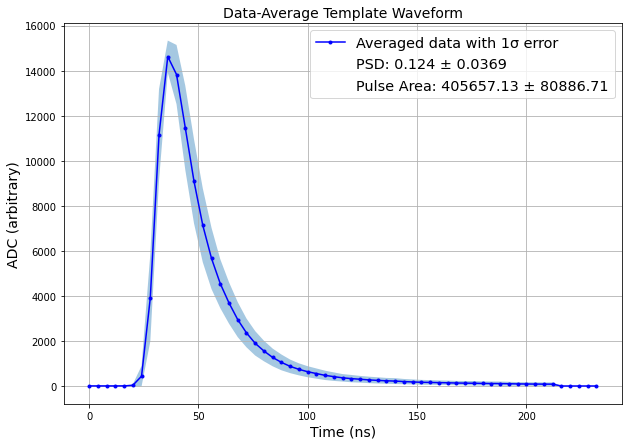

In [13]:
#get average
wow = sum(list(np.asarray(df_heightcut_accumulate_normalized['pulse'])))
wow = wow/len(list(np.asarray(df_heightcut_accumulate_normalized['pulse'])))

# get standard deviation
st = np.asarray(df_heightcut_accumulate_normalized['pulse'])
st = np.stack(st)
stdev = np.std(st, axis=0)

# multiply by 4 to convert to ns
xtemplate = np.arange(len(wow))*4 
ytemplate = wow

plt.rcParams['figure.figsize'] = [10, 7]
waveform, = plt.plot(xtemplate, ytemplate, color='blue', marker='.')
plt.fill_between(xtemplate, ytemplate+stdev, ytemplate-stdev, alpha=0.4)

plt.grid()
plt.xlabel('Time (ns)',fontsize=14); plt.ylabel('ADC (arbitrary)',fontsize=14)
plt.title('Data-Average Template Waveform', fontsize=14)
plt.rcParams["figure.figsize"] = (9,6)

# get PSD range (uncertainty is the maximum difference of the two)
psd = get_PSD_discretepts(xtemplate, ytemplate)
psd_high = get_PSD_discretepts(xtemplate, ytemplate+stdev)
psd_low = get_PSD_discretepts(xtemplate, ytemplate-stdev)
psd_error = max(abs(psd-psd_low), abs(psd-psd_high))
psd_string ="PSD: "+str(round(psd,4)) + " \u00B1 " + str(round(psd_error,4))

# get area range (uncertainty is the maximum differnece of the two)
area = get_total_area_discretepts(xtemplate, ytemplate)
area_high = get_total_area_discretepts(xtemplate, ytemplate+stdev)
area_low = get_total_area_discretepts(xtemplate, ytemplate-stdev)
area_error = max(abs(area-area_low), abs(area-area_high))
area_string ="Pulse Area: "+str(round(area,2)) + " \u00B1 " + str(round(area_error,2))

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend([waveform, extra, extra], ["Averaged data with 1\u03C3 error", psd_string, area_string], fontsize = 'x-large')

### Discussion ###
The waveform derived by combining many measured pulses is displayed above. Furthermore, a $1 \sigma$ error is illustrated. The PSD is estimated as $0.124 \pm 0.0369$ with a total area estimated as $405657.13 \pm 808861.71$ units. values were estimated using a modified computation to allow for the more describe space between ADC samples 
observed in data. This template may be tested against toy clipping problems and simulated measurements. 

## Arbitrary Clipping ##
Next, we will investigate how this template behaves when scaled and clipped. This behavior is used for construcing the appropriate mapping between PSD and timing offest in clipped pulses.

### Method ###
The PSD and time computations are tested by copying the waveform 6 times. Each copy is clipped at integer multiples of their original height. The first is clipped immediately, the second begins to clip beyond twice its maximum, the third at three times its maximum and so forth. Each copied waveform is scaled by an arbitrarily small amount $dh$ up to a maximum $h_{max}$. In this case, $h_{max} = 80h_0$. The new area, PSD and time are recorded, and a plot of the timing offset as a function of PSD is produced.   
 

In [14]:
#create an array of scaled pulses where clipping occures at a multiple of it's max height
df_x1 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate), descrete=True)
df_x2 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate)*2, descrete=True)
df_x3 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate)*3, descrete=True)
df_x4 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate)*4, descrete=True)
df_x5 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate)*5, descrete=True)
df_x6 = scaling_scan(hmin=1, hmax=np.amax(ytemplate)*80, xarray=xtemplate, yarray=ytemplate, clipping_height=np.amax(ytemplate)*6, descrete=True)

dfarray = [[df_x1, 1], [df_x2, 2], [df_x3, 3], [df_x4, 4], [df_x5, 5], [df_x6, 6]]

psd_time_map = {};
for df in dfarray: # combine the curves together
    for i in range(len(np.asarray(df[0]['PSD_clipped']))):
        psd_time_map[np.asarray(df[0]['PSD_clipped'])[i]] = np.asarray(df[0]['time_offset'])[i]
    
lists = sorted(psd_time_map.items()) # sorted by key, return a list of tuples
psd_map, time_map = zip(*lists) # unpack a list of pairs into two tuples

The map between the timing offset and the clipped PSD is implemented as a sorted dictionary. This combines all six waveform copies into one data structure. Furthermore, since the mapping is assumed to be *one to one and onto,* a dictionory ensures that their are no repationts in the PSD domain. In this case, the dictionary keys are the PSD, and the values are the timing offset in nanoseconds. 

<Figure size 2100x900 with 0 Axes>

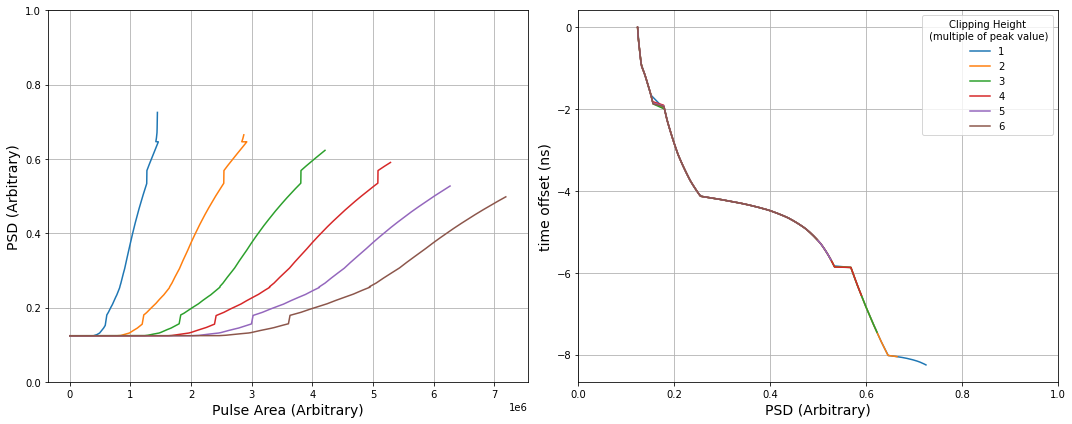

In [15]:
#plot the change in PSD as the pulse scales as well as the PSD vs time offset
plt.figure(figsize=(14, 6), dpi=150)
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,6))

for df in dfarray: 
    ax[0].plot(np.asarray(df[0]['totalarea_clipped']), np.asarray(df[0]['PSD_clipped']), marker='', linestyle='-', label=str(df[1]))
    ax[1].plot(np.asarray(df[0]['PSD_clipped']), np.asarray(df[0]['time_offset']), marker='', linestyle='-')

ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlabel('Pulse Area (Arbitrary)', fontsize=14) 
ax[0].set_ylabel('PSD (Arbitrary)', fontsize=14)

ax[1].grid()
ax[1].set_xlim(0,1)
ax[1].set_xlabel('Waveform Area (Arbitrary)', fontsize=14)
ax[1].set_xlabel('PSD (Arbitrary)', fontsize=14)
ax[1].set_ylabel('time offset (ns)', fontsize=14) 

#transfer the handles and lables from ax[0] to ax[1]
lines_labels = [x.get_legend_handles_labels() for x in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
leg = ax[1].legend(lines, labels, title = 'Clipping Height\n (multiple of peak value)') 
plt.setp(leg.get_title(), multialignment='center')

plt.tight_layout()

### Discussion ###
Due to the discrete distribution of ADC samples within measured data, the PSD and area calculations have large discontinuities. Regardless of where the clipping begins, the trends in the data are consistent. 

## Time Corrections Test ##
The arrays corresponding to the PSD and time offset represent the mapping for events within the *s011_f00001_ts1520181395* file. Regardless, the timing offset correction can be applied to clipped waveforms. To demonstrate, we will use an arbitrary template waveform and scale it. When it begins to clip, the map is applied. 

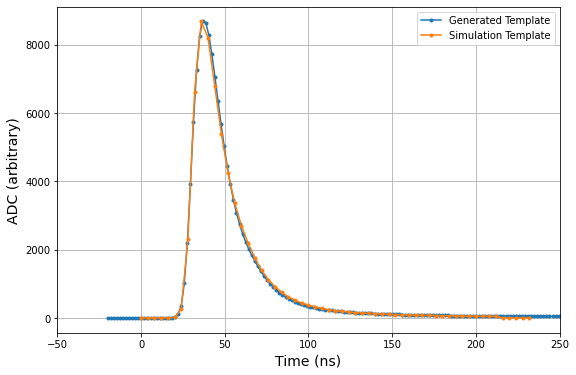

In [16]:
templatefile = ROOT.TFile.Open('Templates/sim/AD_Templates.root',"READ")
graph_early = templatefile.Get("gPSD_Template_3_0")
temp_x, temp_y = get_xy_from_TGraph(graph_early)

xscale = 1
yscale = np.amax(temp_y)/np.amax(wow) 

# scale the data template 
xparam = np.arange(len(wow))*4
xparam = np.arange(len(wow))*4
yparam = wow*yscale

xshift = 30
sim_template_waveform = plt.plot(temp_x + xshift, temp_y, marker='.', label ="Generated Template") # simulation template
data_template_waveform = plt.plot(xparam, yparam, marker='.', label = "Simulation Template")       # data template
plt.xlim(-50, 250)
plt.grid()

plt.xlabel('Time (ns)',fontsize=14); plt.ylabel('ADC (arbitrary)',fontsize=14)
plt.legend()

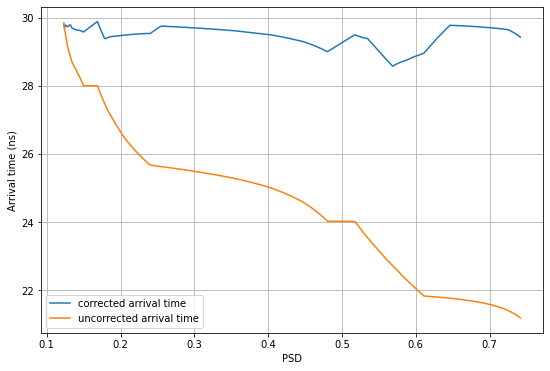

In [17]:
temp_y_sample_points = np.interp(xparam, temp_x+xshift, temp_y)
clip_heights = np.linspace(100, np.amax(temp_y_sample_points), 10000)
time_list = np.asarray([]); time_list_corrected = np.asarray([]);
psd_list = np.asarray([])

index = 0
for h in clip_heights: 
    index = index +1
    temp_y_sample_points_clipped = np.copy(temp_y_sample_points)
    temp_y_sample_points_clipped[temp_y_sample_points_clipped > h] = h
    
    psd = get_PSD_discretepts(xparam, temp_y_sample_points_clipped)
    psd_list = np.append(psd_list, psd)
    
    time = get_time(xparam, temp_y_sample_points_clipped) 
    time_temp = np.interp(psd, psd_map, time_map) 
    time_corrected = time - time_temp 
 
    #print(str(time)+"ns to " +str(time_corrected)+"ns, added " +str(time_temp)) 
    #print("PSD: " +str(psd)+"\n")
    
    time_list = np.append(time_list, time)
    time_list_corrected = np.append(time_list_corrected, time_corrected)


plt.plot(psd_list, time_list_corrected, label='corrected arrival time')
plt.plot(psd_list, time_list, label='uncorrected arrival time')
plt.ylabel('Arrival time (ns)')
plt.xlabel('PSD')
plt.grid()
plt.legend()

In [18]:
# write the map to file
bool write_to_file = False 

if(write_to_file == true):
    with open('PSD_Time_map.txt', 'w') as f:
        for i in range(0, len(psd_map)): 
            f.write('%s: %s\n' % (psd_map[i], time_map[i]))

### Discussions ###
After normalizing, the generated waveform template follows the same trend as the AD1-waveform used in simulations. Furthermore, the clipping effect is undone after the PSD-time map was applied to the AD1-waveform. The correction is, however, imperfect. The discontinuities in the map result in imprecise corrections. This is most noticeable near a PSD of 0.2 and 0.525. In practice, the PSD is only appropriately defined in a short range. A more appropriate domain is restricted within $PSD \leq 0.25$.   

## Summary ## 
Using a collection of measured waveforms from the PROSPECT AD1 detector, a new template waveform was generated. Arguably, this waveform better reflects the behaviors of measured data. Furthermore, we have shown that a PSD-time offset map generated from this template can undo the clipping observed in other templates.  

Since this template was generated using measurements within the s011_f00001_ts1520181395 file, the observed behaviors displayed in this analysis may only be true for that sample of measurement. Additional templates may, however, be generated and tested against other sets of data. Furthermore, since we have shown that the toy studies of clipped pulses can be resolved, it is now necessary to apply this transformation to calibrated samples. 